In this kernel, I will be talking about the methods that will help in better understanding of the problem statement and visualisation of the data. I will also provide links of useful resources and information.

The script is written in Python. I recommend people to install anaconda on their desktop because of its advantages mentioned [here][1]. The libraries that will be used in this tutorial for reading, processing and visualisation of data are matplotlib, numpy, skimage and [pydicom][2]. 

The images are of size (z, 512, 512) where z is the number of slices in the CT Scan and varies depending on the resolution of the scanner. Such large images cant be fed directly into a Convolution Network architectures because of the limit on the computation power. Thus we will have to find the regions that are more probable of having cancer. We will be reducing our search space by first segmenting the lungs and then removing the low intensity regions. 

In this tutorial, we will first start with reading the dataset and visualising it. After that, we will be segmenting the lung structures and then find the region of interest(possible cancer regions) in the CT Scans using Image processing methods. Then I will talk about how to preprocess LUNA16 dataset for training architectures like UNet for segmentation and candidate classification.

The segmentation of lung structures is very challenging problem because homogeneity is not present in the lung region, similar densities in the pulmonary structures, different scanners and scanning protocols. The segmented lungs can be further used to find the lung nodule candidates and regions of interest which may help in better classification of the CT Scans. Finding the lung nodule regions is a very hard problem because there are nodules that are attached to the blood vessels or are present at the boundary of the lung region. The lung nodule candidates can be further used for classification by cutting 3D voxels around them and passing it through a 3D CNNs which can be trained on LUNA16 dataset. The LUNA 16 dataset has the location of the nodules in each CT Scan thus will be useful for training the classifier. 

  [1]: https://www.reddit.com/r/Python/comments/3t23vv/what_advantages_are_there_of_using_anaconda/
  [2]: http://pydicom.readthedocs.io/en/stable/getting_started.html

**Reading a CT Scan**
-----------------
The input folder has three things, one is the sample_images folders which has the sample CT Scans. The `stage1_labels.csv` contains the cancer ground truth for the stage 1 training set images and `stage1_sample_submission.csv` shows the submission format for stage 1. 

In [4]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
CODE_HOME_DIR = current_dir
DATA_HOME_DIR = CODE_HOME_DIR + '/../input/'
print(CODE_HOME_DIR)
print(DATA_HOME_DIR)

D:\Dropbox\Ted 2017\11A_技術\[TREND] Data Science and ML\[Tutorials] Kaggle\[Competitions] Kaggle Competitions\2017_Segmentation_Data Bowl 2017\Code\Tutorials
D:\Dropbox\Ted 2017\11A_技術\[TREND] Data Science and ML\[Tutorials] Kaggle\[Competitions] Kaggle Competitions\2017_Segmentation_Data Bowl 2017\Code\Tutorials/../input/


In [7]:
#%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + 'sample_images/' # + '/'
'''
results_path = path + 'results/'
train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.makedirs(model_path)
''' 
batch_size = 64

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import numpy as np

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
print(check_output(["ls", "../../input"]).decode("utf8"))

Data Description.docx
Data Description.txt
LUNA16
data_password.txt
data_password.txt.zip
sample_images
sample_images.7z
stage1_labels.csv
stage1_sample_submission.csv
stage1_sample_submission.csv.zip
stage1_solution.csv
~$ta Description.docx



Each 3D CT Scan consists of many slices, whose number depends on the resolution of the scanner and each slice has a Instance Number associated with it which tells the index of the slice from the top. All the dicom files for a CT Scan are inside one folder having the CT Scan's name. Now we will read all the dicom slices for a scan and then stack them with respect to their Instance Number to get the 3D Lung CT Scanned Image.

The sample_images folder has around 20 folders each corresponding to one CT Scan. Inside the folder there are many dicom files. 

In [3]:
print(check_output(["ls", "../../input/sample_images/"]).decode("utf8"))

00cba091fa4ad62cc3200a657aeb957e
0a099f2549429d29b32f349e95fb2244
0a0c32c9e08cc2ea76a71649de56be6d
0a38e7597ca26f9374f8ea2770ba870d
0acbebb8d463b4b9ca88cf38431aac69
0b20184e0cd497028bdd155d9fb42dc9
0bd0e3056cbf23a1cb7f0f0b18446068
0c0de3749d4fe175b7a5098b060982a1
0c37613214faddf8701ca41e6d43f56e
0c59313f52304e25d5a7dcf9877633b1
0c60f4b87afcb3e2dfa65abbbf3ef2f9
0c98fcb55e3f36d0c2b6507f62f4c5f1
0c9d8314f9c69840e25febabb1229fa4
0ca943d821204ceb089510f836a367fd
0d06d764d3c07572074d468b4cff954f
0d19f1c627df49eb223771c28548350e
0d2fcf787026fece4e57be167d079383
0d941a3ad6c889ac451caf89c46cb92a
0ddeb08e9c97227853422bd71a2a695e
0de72529c30fe642bc60dcb75c87f6bd



Each CT Scan consists of multiple 2D slices which are provided in a DICOM format. At first, I will read the random dicom file of a CT Scan. After reading the image file, we will update the intensity values of -2000 with 0 because they are the pixels that fall outside of the scanner bounds.

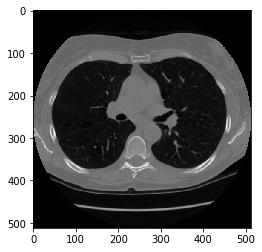

In [4]:
# Any results you write to the current directory are saved as output.
lung = dicom.read_file('../../input/sample_images/00cba091fa4ad62cc3200a657aeb957e/38c4ff5d36b5a6b6dc025435d62a143d.dcm')

slice = lung.pixel_array
slice[slice == -2000] = 0
plt.imshow(slice, cmap=plt.cm.gray)

In [5]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

In [6]:
ct_scan = read_ct_scan('../../input/sample_images/00cba091fa4ad62cc3200a657aeb957e/') 

To visualise the slices, we will have to plot them. `matplotlib` is used for plotting the slices. The `plot_ct_scan` function takes a 3D CT Scanned Image array  as input and plots equally spaced slices. The CT Scans are grayscale images i.e. the value of each pixel is a single sample, which means it carries only intensity information.

In [37]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

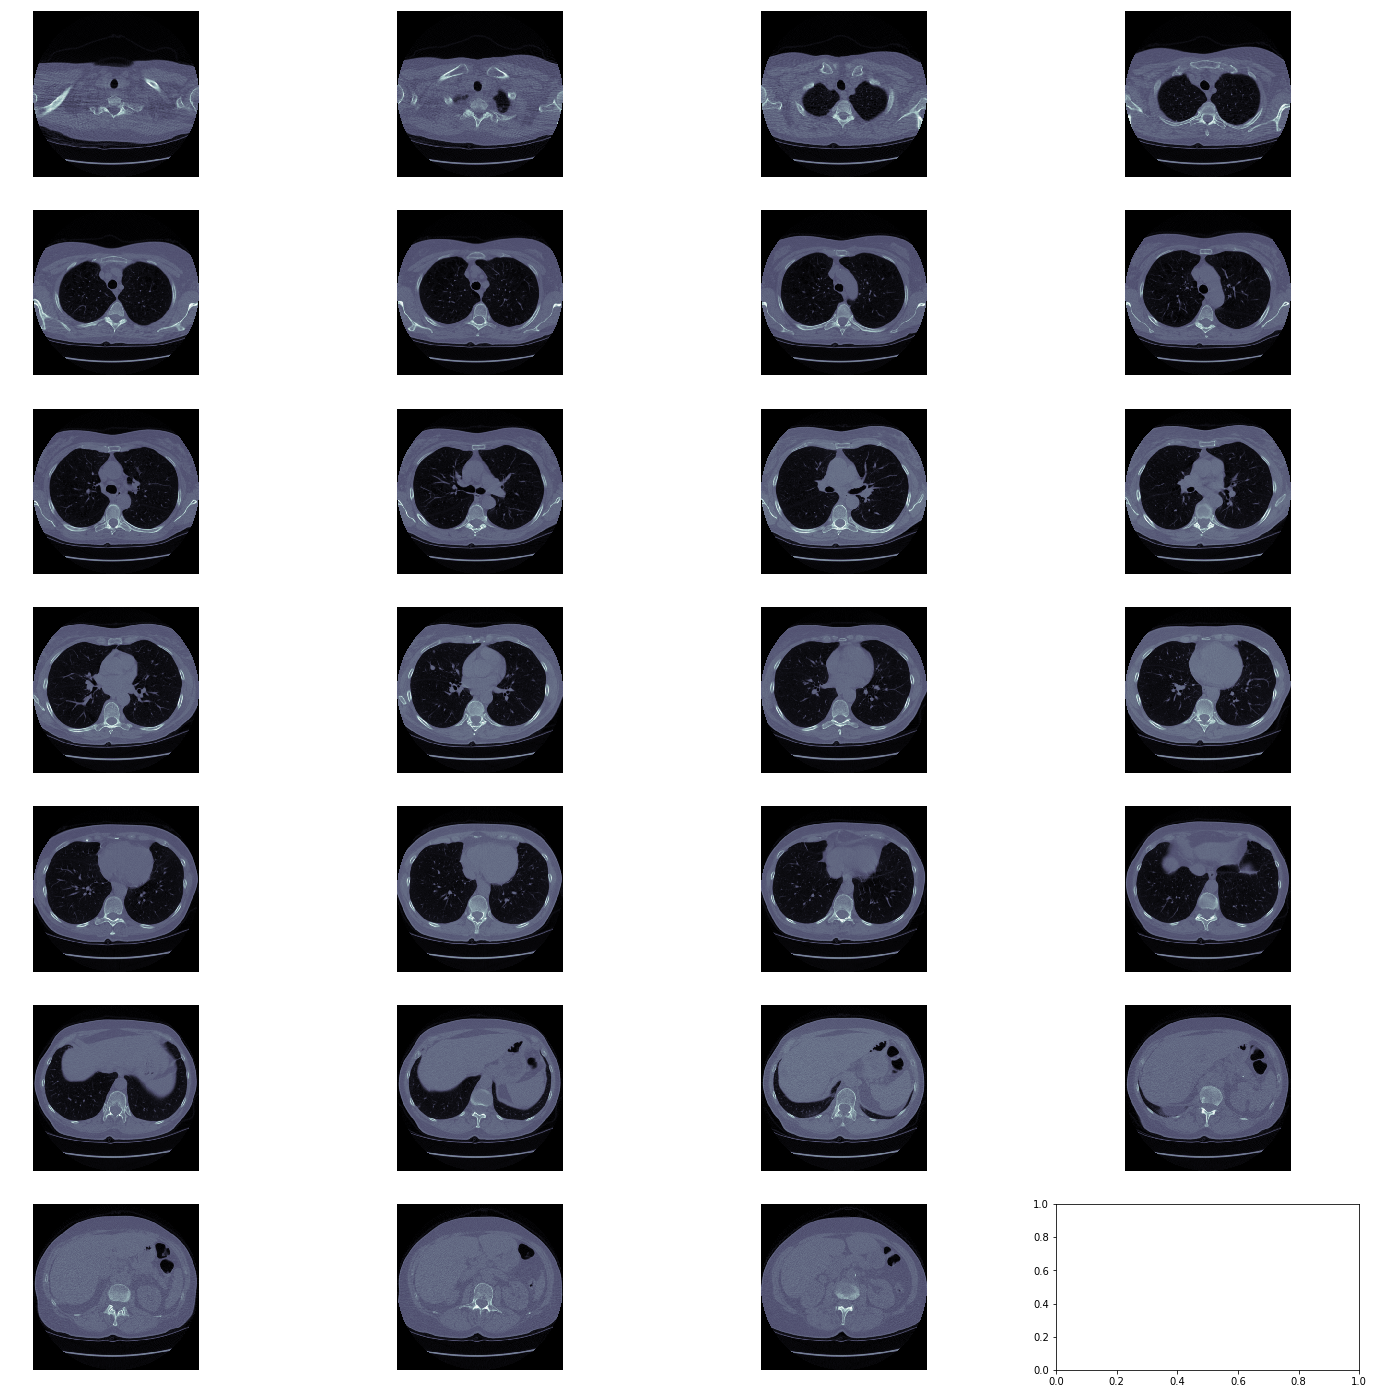

In [38]:
plot_ct_scan(ct_scan)

## Segmentation of Lungs ##
After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. It is visible that the lungs are the darker regions in the CT Scans. The bright region inside the lungs are the blood vessels or air. A threshold of 604(-400 HU) is used at all places because it was found in experiments that it works just fine. We segment lung structures from each slice of the CT Scan image and try not to loose the possible region of interests attached to the lung wall. There are some nodules which may be attached to the lung wall.

I will first explain a common method using simple Image Processing and Morphological operations to segment the lungs and then will give references and summaries to good links of papers. 

In [39]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].set_title('Step 1: Convert into a binary image. ')
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].set_title('Step 2: Remove the blobs connected to the border of the image.')
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].set_title('Step 3: Label the image.')
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].set_title('Step 4: Keep the labels with 2 largest areas.')
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].set_title('''Step 5: Erosion operation with a disk of radius 2. This operation is \n  
    seperate the lung nodules attached to the blood vessels.''')
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].set_title('''Step 6: Closure operation with a disk of radius 10. This operation is \n
    to keep nodules attached to the lung wall.''')
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].set_title('Step 7: Fill in the small holes inside the binary mask of lungs.')
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].set_title('Step 8: Superimpose the binary mask on the input image.')
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

The `get_segmented_lungs` function segments a 2D slice of the CT Scan. I have outputted the slice after all steps for better visualisation and understanding of the code and applied operations.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

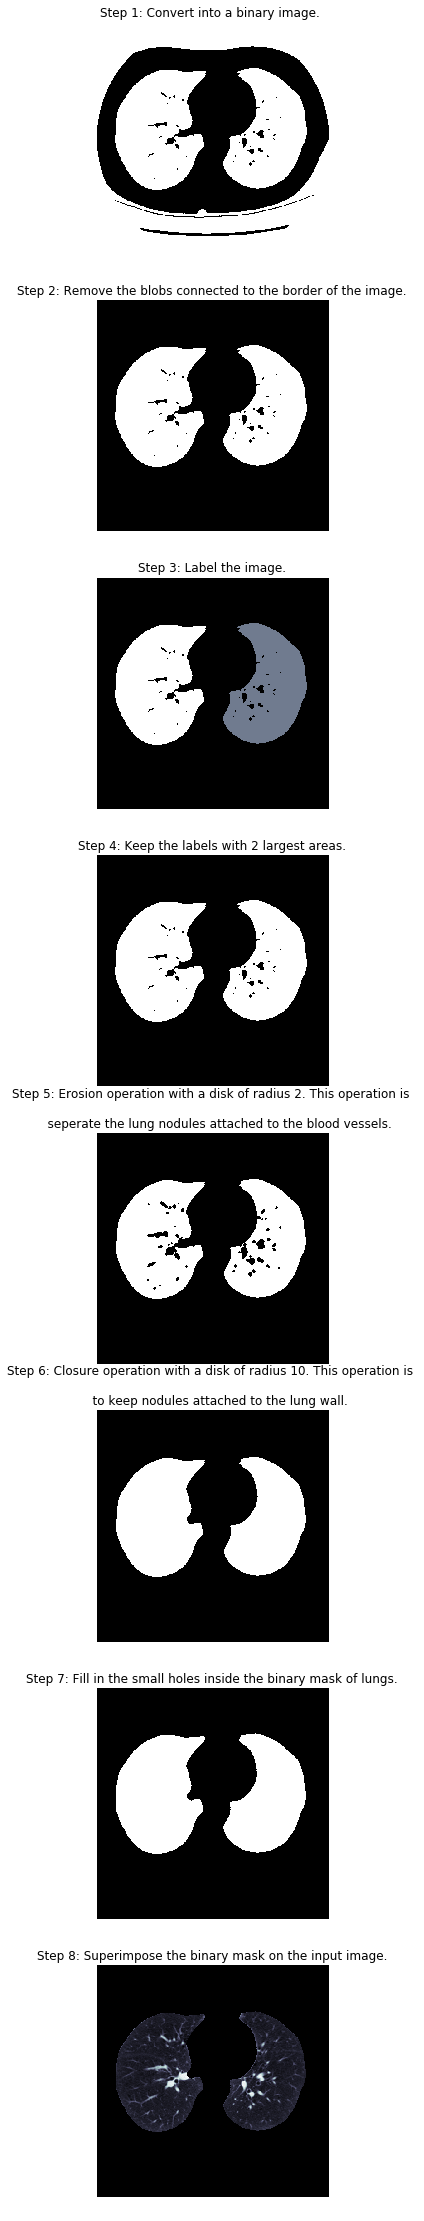

In [40]:
get_segmented_lungs(ct_scan[71], True)

Now, I will segment the whole CT Scan slice by slice and show some slices of the CT Scan.

In [41]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

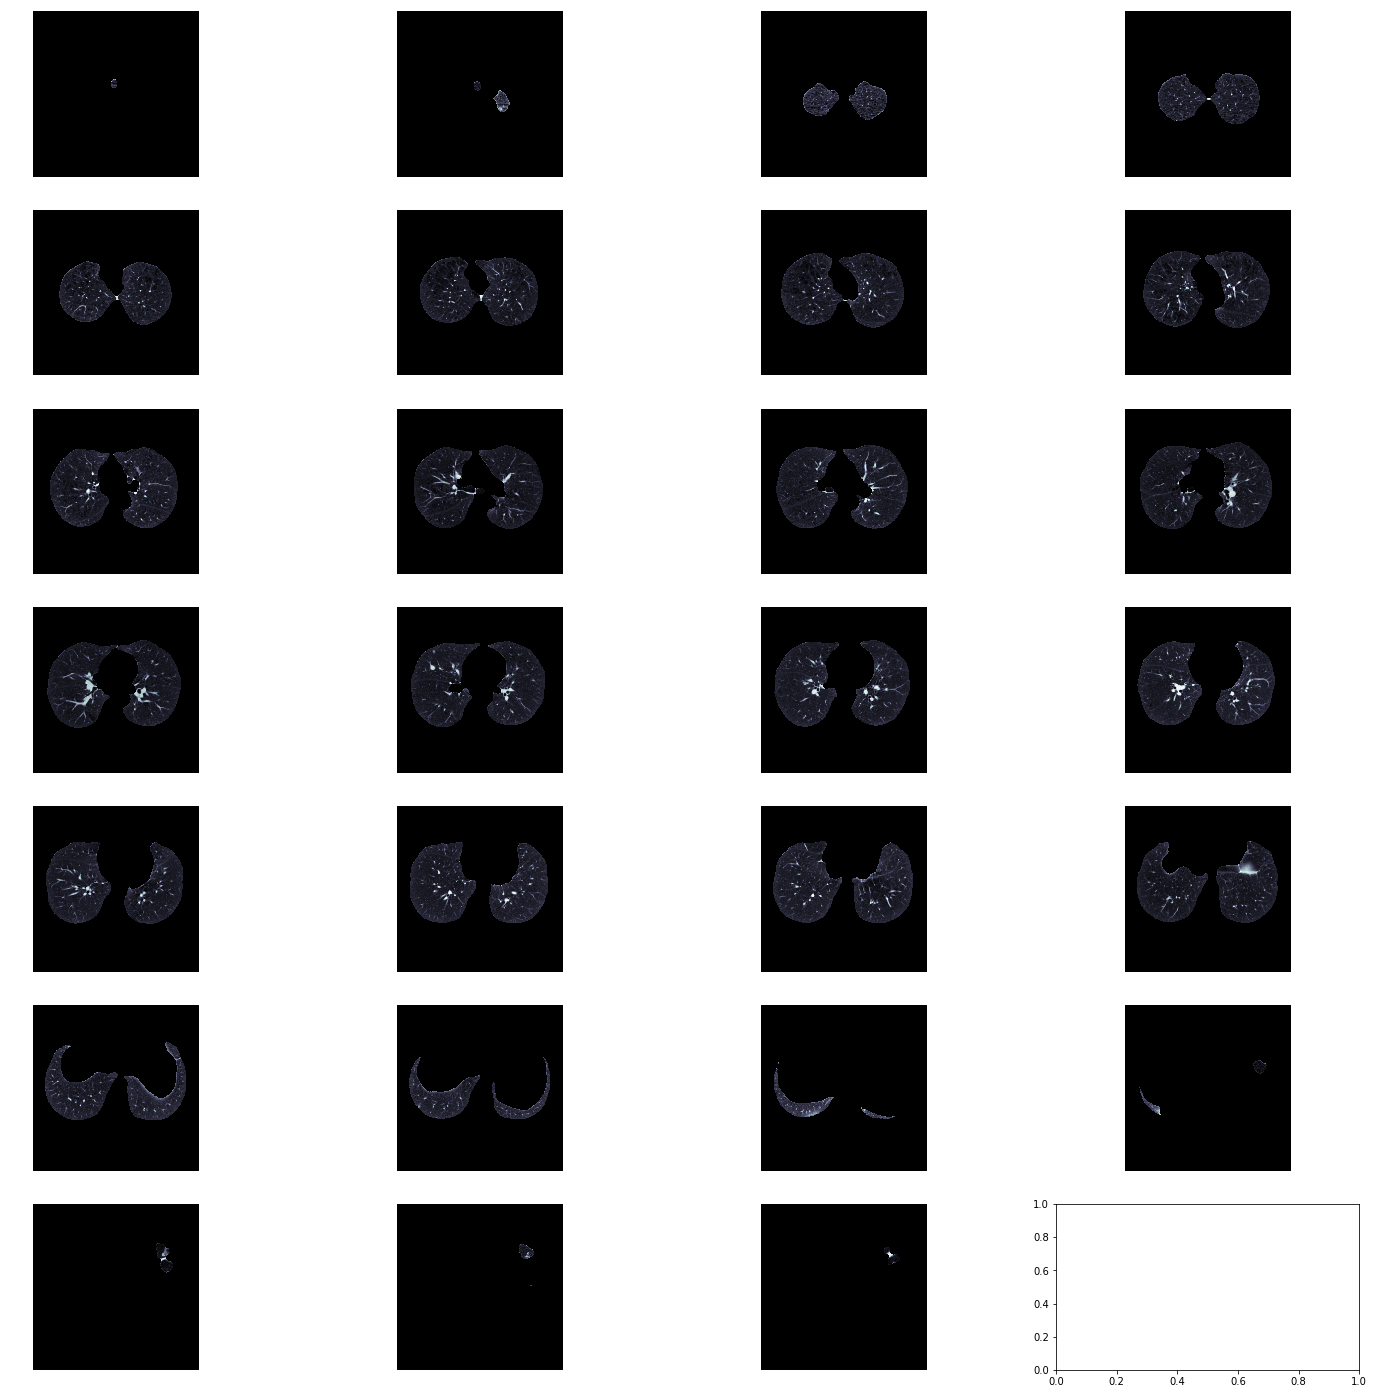

In [42]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
plot_ct_scan(segmented_ct_scan)

Nodule Candidate/Region of Interest Generation
---------------------------
After segmenting the lung structures from the CT Scanned images, our task is to find the candidate regions with nodules since the search space is very large. Also, whole image can't be classified directly using 3D CNNs due to limit on computation, we need to find possible regions of cancer and then classify them. It was found in experiments that all the region of interests have intensity >  604(-400 HU). So, we used this threshold to filter the darker regions. This reduces the number of candidates by a large number and preserves all the important regions with high recall. We then classify all the candidate points to reduce the False Positives.

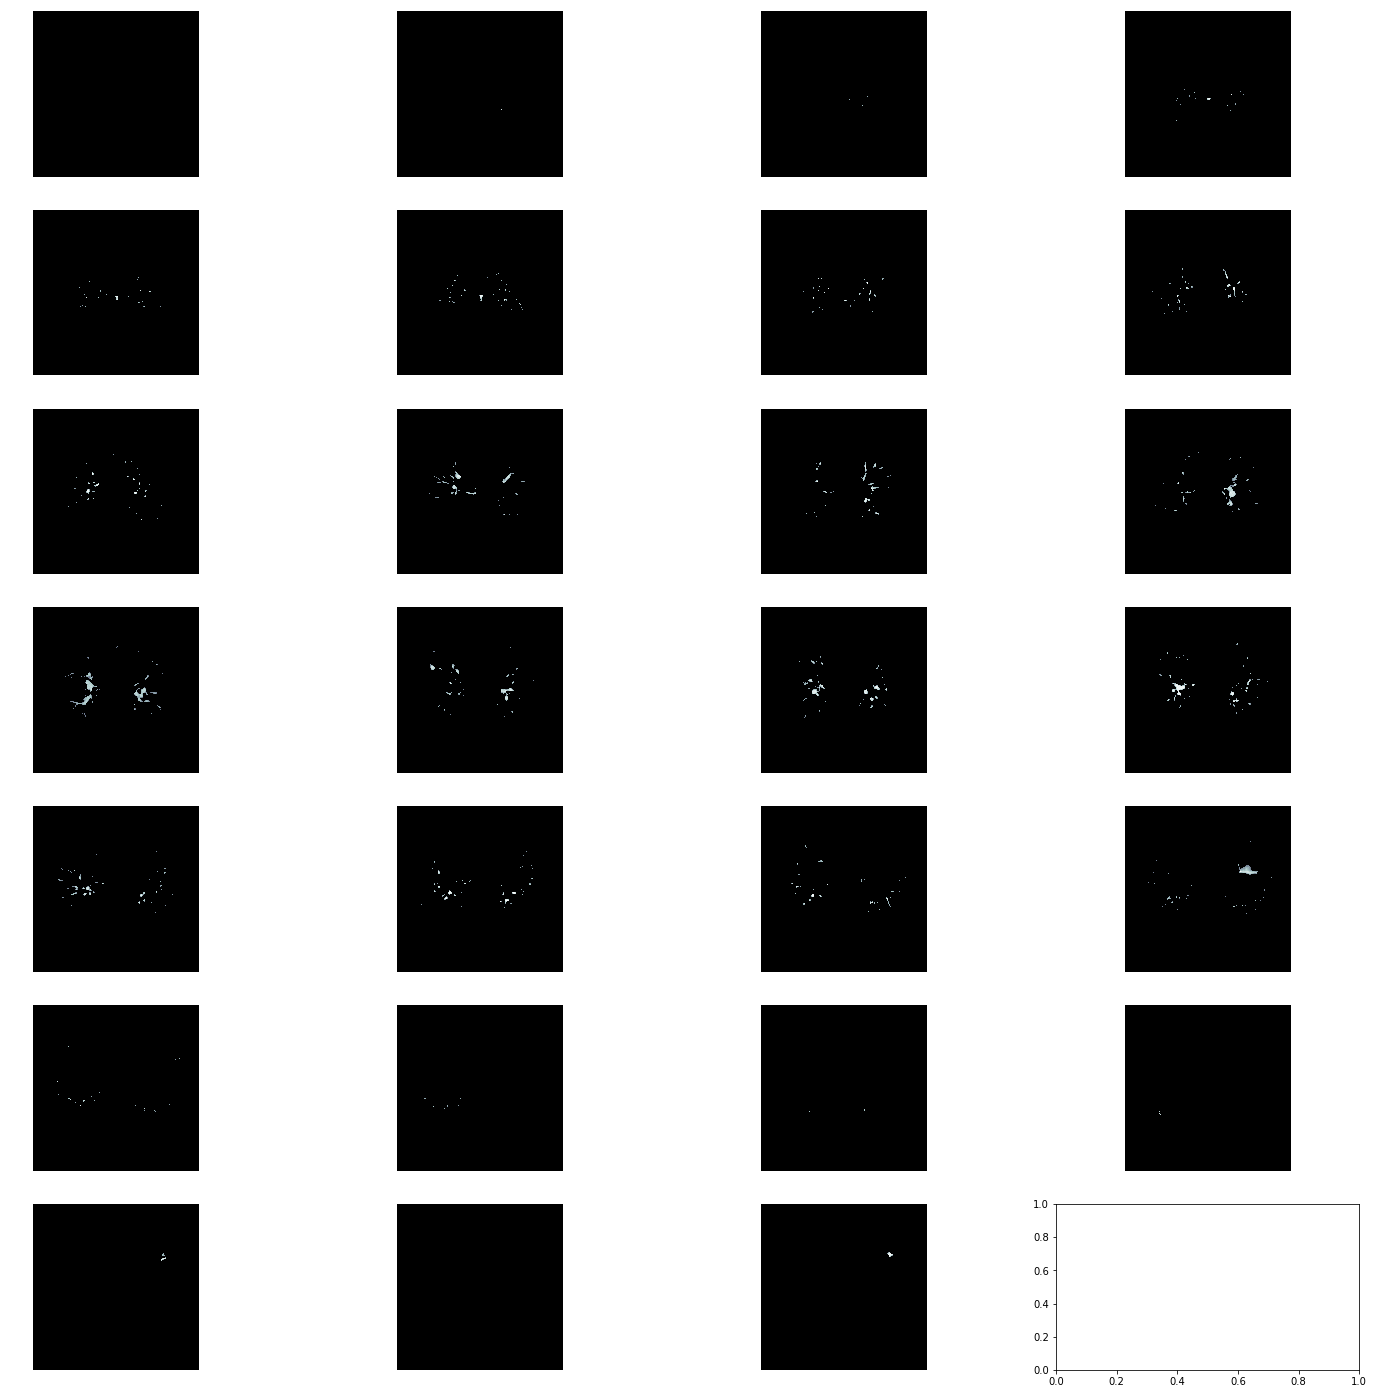

In [43]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
plot_ct_scan(segmented_ct_scan)

After filtering, there are still lot of noise because of blood vessels. Thus we further remove the two largest connected component.

In [44]:
selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

The `plot_3d` function plots the 3D numpy array of CT Scans. 

In [47]:
measure.marching_cubes?

In [48]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

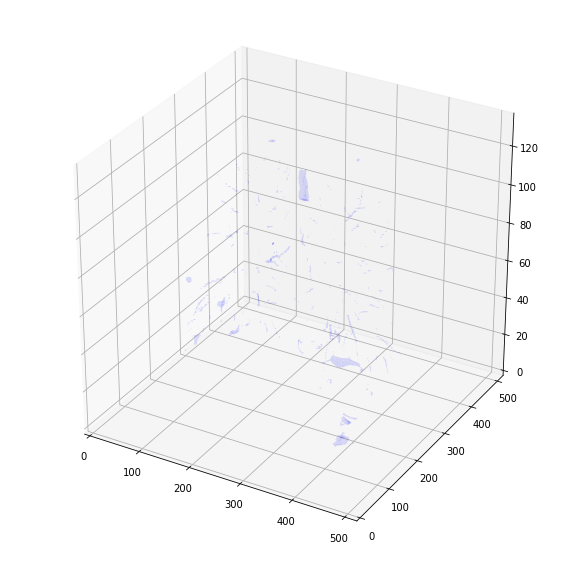

In [49]:
plot_3d(segmented_ct_scan, 604)

There are more methods that can be tried to get the regions of interest.

 1.  The left blood vessels can further be filtered using shape properties because we know that nodules are spherical in shape.
 2. Super pixel segmentation can be further used and shape properties can be applied on segmented regions.
 3. CNN architectures like UNet can also be used to generate candidate regions of interest. 

There are also a lot of good papers on Lung Segmentation and Nodule Candidate generation using Image Processing methods. I am posting the methods with a little summary of all of them:

 1. [Automatic segmentation of lung nodules with growing neural gas and support vector machine][1]- The proposed method consists of the acquisition of computerized tomography images of the lung, the reduction of the volume of interest through techniques for the extraction of the thorax, extraction of the lung, and reconstruction of the original shape of the parenchyma. After that, growing neural gas (GNG) is applied to constrain even more the structures that are denser than the pulmonary parenchyma (nodules, blood vessels, bronchi, etc.). The next stage is the separation of the structures resembling lung nodules from other structures, such as vessels and bronchi. Finally, the structures are classified as either nodule or non-nodule, through shape and texture measurements together with support vector machine.
 2. [Automated Segmentation of Lung Regions using Morphological Operators in CT scan][2]- The `get_segmented_lungs` method is a little modification of this paper. The threshold of 604 was taken from this paper.
 3. [Pre-processing methods for nodule detection in lung CT][3]- This paper has used dot enhancement
filter applied to the 3D matrix of voxel data. This 3D filter attempts to determine local geometrical characteristics for each voxel, computing the eigenvalues of the Hessian matrix and evaluating a  "likelihood" function that was purposely built to discriminate between local morphology of linear, planar and spherical objects, modeled as having 3D Gaussian sections (Q. Li, S. Sone and K. Doi [6]). By applying this 3D filter to artificial images, we have verified the efficiency in detecting the Gaussian-like regions even in the cases were they are superimposed to non-Gaussian ones.
 4. [Lung Nodule Detection using a Neural Classifier][4]: This paper discusses a dot-enhancement filter for nodule candidate selection and a neural classifier for false-positive finding reduction. The  performance is evaluated as a fully automated computerized method for the detection of lung nodules in screening CT in the identification of lung cancers that may be missed during visual interpretation. 

Next I will be discussing about preprocessing of the LUNA16 dataset and using it to train the UNet model.


  [1]: http://www.sciencedirect.com/science/article/pii/S0010482512001412
  [2]: http://www.ijser.org/onlineResearchPaperViewer.aspx?Automated-Segmentation-of-Lung-Regions-using-Morphological-Operators-in-CT-scan.pdf
  [3]: https://arxiv.org/pdf/physics/0507153.pdf
  [4]: http://www.ijetch.org/papers/136-D058.pdf

UNET for Candidate Point Generation
-----------------------------------

Nowadays, Deep Learning methods are achieving good results in Segmentation problems in medical imaging. One very famous architecture is UNET, which can be used for Nodule Candidates Points Generation in our case. Training of these networks is done using annotated datasets. The image processing methods used for candidate points generation above does not need any training data. We use the LUNA16 dataset for training our UNET model. 

In the LUNA16 dataset, each CT Scan is annotated with nodule points and the radius of the nodule which is used to generate the binary mask.  I will first talk about preprocessing of the LUNA16 dataset. In the dataset, the CT Scans are saved in '.mhd' files and SimpleITK is used to read the image.  I have defined three functions:

 - **load_itk** - Used to read a CT_Scan for the '.mhd' file.
 - **world_2_voxel**- Convert world coordinates to voxel coordinates.
 - **voxel_2_world**- Convert voxel coordinates to world coordinates.

In [50]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

After reading the 3D CT Scans, we will first segment the lungs and then generate the binary mask of nodule regions. This will be done by the `create_nodule_mask` function.  The `draw_circle` function is used to mark the nodule regions in the binary mask. 'cands' are the list of nodule points with the radius given in the `annotation.csv` file of LUNA16 dataset. At the end we save the resized CT Scan with its segmented lungs and binary mask of nodules.

In [34]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ca in cands.values:
        #get middel x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        image_mask[np.round(coords[0]),np.round(coords[1]),np.round(coords[2])] = int(1)
    
    return image_mask

'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, maskPath, cands):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize

    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
    lung_img = lung_img + 1024
    lung_mask = segment_lung_from_ct_scan(lung_img)
    lung_img = lung_img - 1024

    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape	
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = np.round(offset/2)
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
    np.save(imageName + '_lung_img.npz', lung_img_512)
    np.save(imageName + '_lung_mask.npz', lung_mask_512)
    np.save(imageName + '_nodule_mask.npz', nodule_mask_512)
        

After preprocessing the dataset, the next thing is to train the model for segmentation. The model is written in keras in the `unet_model` function. It takes a 2D slice as input and returns a 2D slice of the same size as output. There are few things to be kept in mind while training

 - We wont use the slices that has no nodule region in the mask for training.
 - Dataset augmentation is very important because are nodules are generally circular or spherical in shape and are of different radius. 
 - Since the nodule regions are very less, the dataset is skewed. Thus, we should weight the loss function accordingly.
 - The model may overfit on the training dataset. Thus, Dropout or Spatial Dropout are used to avoid overfitting.

In [35]:
# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

'''
The UNET model is compiled in this function.
'''
def unet_model():
    inputs = Input((1, 512, 512))
    conv1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.summary()
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

## Classification of Lung Nodules ##

The candidate regions generated still has a lot of noise. Thus we need a classifier to classify the candidates as either Nodule or Non-Nodule.  This is also referred to as False Positive Reduction step.  I am sharing a list of useful resources with a summary of all of them:

 1. [Pulmonary Nodule Classification with Convolutional Neural Networks][1]: They use a CNN to predict
whether the image contains a pulmonary lesion. As baselines, they also look at using SVM, kNN, and logistic regression to perform the same task. LIDC dataset is used for training and the classification results are very good.
 2. [Pulmonary Nodule Classification with Deep Convolutional Neural Networks on Computed Tomography Images][2]: They design a deep convolutional neural networks method for nodule classification, which has an advantage of autolearning representation and strong generalization ability. A specified network structure for nodule images is proposed to solve the recognition of three types of nodules, that is, solid, semisolid, and ground glass opacity (GGO). Deep convolutional neural networks are trained by 62,492 regions-of-interest (ROIs) samples including 40,772 nodules and 21,720 nonnodules from the Lung Image Database Consortium (LIDC) database. Experimental results demonstrate the effectiveness of the proposed method in terms of sensitivity and overall accuracy and that it consistently outperforms the competing methods.
 3. [Deep Learning for the Classification of Lung Nodules][3]: They have trained a CNN and tested the results on different datasets.  In order to understand the features of lung nodules, they further construct new datasets, based on the combination of artificial geometric nodules and some transformations of the original images, as well as a stochastic nodule shape model.
 4. [Lung Nodule Classification Based on Deep Convolutional Neural Networks][4]: In this work, they present a method for classifying lung nodules based on CNNs. Training is performed by balancing the mini-batches on each stochastic gradient descent (SGD) iteration to address the lack of nodule samples compared to background samples. They show that the method outperforms a base feature-engineering method using the same techniques for other stages of lung nodule detection, and show that CNNs obtain competitive results.


  [1]: http://cs231n.stanford.edu/reports2016/324_Report.pdf
  [2]: https://www.hindawi.com/journals/cmmm/2016/6215085/
  [3]: https://arxiv.org/abs/1611.06651
  [4]: http://www.liv.ic.unicamp.br/~juliomb/resources/2016-lnc-ciarp.pdf

Due to computational limitations the size of each cannot very large too. I will be considering cubic voxels of size 36. In the dataset, we have 1187 nodule points, which is a very less number for training a deep network. Thus we can cut many voxels around a nodule center and increase the size of the dataset for training. We will also sample equal number of negative examples from the image for training. The code for preprocessing the LUNA16 dataset is below:

In [36]:
'''
This function takes the numpy array of CT_Scan and a list of coords from
which voxels are to be cut. The list of voxel arrays are returned. We keep the 
voxels cubic because per pixel distance is same in all directions.
'''
def get_patch_from_list(lung_img, coords, window_size = 10):
    shape = lung_img.shape
    output = []
    lung_img = lung_img + 1024
    for i in range(len(coords)):
        patch =   lung_img[coords[i][0] - 18: coords[i][0] + 18,
                            coords[i][1] - 18: coords[i][1] + 18,
                            coords[i][2] - 18: coords[i][2] + 18]
        output.append(patch)

    return output

'''
Sample a random point from the image and return the coordinates. 
'''
def get_point(shape):
    x = randint(50, shape[2] - 50)
    y = randint(50, shape[1] - 50)
    z = randint(20, shape[0] - 20)
    return np.asarray([z, y, x])

'''
This function reads the training csv file which contains the CT Scan names and
location of each nodule. It cuts many voxels around a nodule and takes random points as 
negative samples. The voxels are dumped using pickle. It is to be noted that the voxels are 
cut from original Scans and not the masked CT Scans generated while creating candidate
regions.
'''
def create_data(path, train_csv_path):
    coords, trainY = [], []

    with open(train_csv_path, 'rb') as f:
        lines = f.readlines()

        for line in lines:
            row = line.split(',')
            
            if os.path.isfile(path + row[0] + '.mhd') == False:
                continue

            lung_img = sitk.GetArrayFromImage(sitk.ReadImage(path + row[0] + '.mhd'))

            for i in range(-5, 5, 3):
                for j in range(-5, 5, 3):
                    for k in range(-2, 3, 2):
                        coords.append([int(row[3]) + k, int(row[2]) + j, int(row[1]) + i])
                        trainY.append(True)

            for i in range(60):
                coords.append(get_point(lung_img.shape))
                trainY.append(False)

            trainX = get_patch_from_list(lung_img, coords)

            print (trainX[0].shape, len(trainX))

            pickle.dump(np.asarray(trainX), open('traindata_' + str(counter) + '_Xtrain.p', 'wb'))
            pickle.dump(np.asarray(trainY, dtype = bool),  open('traindata_' + str(counter) + '_Ytrain.p', 'wb'))

            counter = counter + 1
            coords, trainY = [], []

In the processing, there are few things that must be tried:

 1. Do not sample negative examples randomly from CT Scan. Select using the candiate points or the False Positives Generated, because it will train the model to discriminate non-nodule regions better.
 2. Dataset Augmentation should be done while training because the nodules are symmetric regions and of varying sizes, thus dataset augmentation is very likely to help in such cases. Dataset augmentation can implemented using keras given at [this][1] link.

Next is the script for training a classifier with 3D Convolutional Neural Networks. In the preprocessed pickle data files, randomly select 20% files and put it in a seperate folder as test set. The model is trained in keras. 


  [1]: https://keras.io/preprocessing/image/

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D
from keras.utils import np_utils
from keras import backend as K

'''
Creates a keras model with 3D CNNs and returns the model.
'''
def classifier(input_shape, kernel_size, pool_size):
	model = Sequential()

	model.add(Convolution3D(16, kernel_size[0], kernel_size[1], kernel_size[2],
	                        border_mode='valid',
	                        input_shape=input_shape))
	model.add(Activation('relu'))
	model.add(MaxPooling3D(pool_size=pool_size))
	model.add(Convolution2D(32, kernel_size[0], kernel_size[1], kernel_size[2]))
	model.add(Activation('relu'))
	model.add(MaxPooling3D(pool_size=pool_size))
	model.add(Convolution3D(64, kernel_size[0], kernel_size[1], kernel_size[2]))
	model.add(Activation('relu'))
	model.add(MaxPooling3D(pool_size=pool_size))
	model.add(Dropout(0.25))

	model.add(Flatten())
	model.add(Dense(512))
	model.add(Activation('relu'))
	model.add(Dropout(0.5))
	model.add(Dense(128))
	model.add(Activation('relu'))
	model.add(Dropout(0.5))
	model.add(Dense(2))
	model.add(Activation('softmax'))

	return model

def train_classifier(input_shape):
	model = classifier(input_shape, (3, 3, 3), (2, 2, 2))
	model.compile(loss='categorical_crossentropy',
		  optimizer='adadelta',
		  metrics=['accuracy'])
	'''
	Read the preprocessed datafiles chunk by chunnk and train the model on that batch (trainX, trainY) using:'''
	model.train_on_batch(trainX, trainY, sample_weight=None)
	'''The model can be trained on many epochs using for loops'''
	
	'''
	AFter training the dataset we test our model of the test dataset, read the test file chunk by chunk and 
	test on each chunk (trainX, trainY) using:'''
	print (model.test_on_batch(trainX, trainY, sample_weight=None))
	'''The average of all of this can be taken to obtain the final test score.'''
	
	'''After testing save the model using'''
	model.save('my_model.h5')
    

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


This is a simple 3D CNN architecture for classification. There are few things that anyone should try to improve the accuracy:
1) Use of multi-scale CNNs to capture more features for classification.
2) Extract the features of fully connected layers and use xgboost on it to improve classification accuracy.

In summary, we first generate candidates using Image Processing or UNet and then cut voxels around all candidate points and classify them. The points are clustered using DBScan algorithm and probability of a cluster is the mean of probabilities of all points in that cluster. The activation of the fully connected network of the classifier is extracted and this features is created for each CT Scan in our dataset. There is one more xgboost or SVM classifier on our dataset to classify the samples. We take the mean of the probabilities of this classifier as the final output probability.

The code of xgboost classifier for use with trainX containing features and trainY containing labels is below.

In [51]:
'''
A sample code to train xgboost. 
The OptTrain class takes trainX(features) and trainY(labels) as input and initialise the class for 
training the classifier. The optimize function then trains the classifier and the best model is saved
in 'model_best.pkl'.

A sample code is below:
trainX = np.array([[1,1,1], [2,3,4], [2,3,2], [1,1,1], [2,3,4], [2,3,2]])
trainY = np.array([0,1,0,0,0,1])
a = OptTrain(trainX, trainY)
a.optimize()
'''
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.externals import joblib
from sklearn import model_selection
import numpy as np

class OptTrain:
    def __init__(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY

        self.level0 = xgb.XGBClassifier(learning_rate=0.325,
                                       silent=True,
                                       objective="binary:logistic",
                                       nthread=-1,
                                       gamma=0.85,
                                       min_child_weight=5,
                                       max_delta_step=1,
                                       subsample=0.85,
                                       colsample_bytree=0.55,
                                       colsample_bylevel=1,
                                       reg_alpha=0.5,
                                       reg_lambda=1,
                                       scale_pos_weight=1,
                                       base_score=0.5,
                                       seed=0,
                                       missing=None,
                                       n_estimators=1920, max_depth=6)
        self.h_param_grid = {'max_depth': hp.quniform('max_depth', 1, 13, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
                        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
                        'n_estimators': hp.quniform('n_estimators', 100, 1000, 5),
                        }
        self.to_int_params = ['n_estimators', 'max_depth']

    def change_to_int(self, params, indexes):
        for index in indexes:
            params[index] = int(params[index])

    # Hyperopt Implementatation
    def score(self, params):
        self.change_to_int(params, self.to_int_params)
        self.level0.set_params(**params)
        score = model_selection.cross_val_score(self.level0, self.trainX, self.trainY, cv=5, n_jobs=-1)
        print('%s ------ Score Mean:%f, Std:%f' % (params, score.mean(), score.std()))
        return {'loss': score.mean(), 'status': STATUS_OK}

    def optimize(self):
        trials = Trials()
        print('Tuning Parameters')
        best = fmin(self.score, self.h_param_grid, algo=tpe.suggest, trials=trials, max_evals=200)

        print('\n\nBest Scoring Value')
        print(best)

        self.change_to_int(best, self.to_int_params)
        self.level0.set_params(**best)
        self.level0.fit(self.trainX, self.trainY)
        joblib.dump(self.level0,'model_best.pkl', compress=True)

ModuleNotFoundError: No module named 'hyperopt'

I am currently working on training a classifier on the LUNA16 dataset. I will make the results available with dataset augmentation and about making a sample submission on the kernel as soon as it I complete it.

I will post the dataset augmentation functions and Spatial Dropout very soon. I will post more methods as soon I implement them.

After getting the regions of interest, 3D voxels can be cut around regions of interest and used for classification.

**Please upvote or leave a comment, if you liked the tutorial.**